In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('TakeHome_task_data.csv')
pd.set_option('display.max_colwidth', -1)
df.head(5)

,data,label,new_label
0,"{'id': 'KG0OUA', 'data': 'Good morning', 'message_order': 2, 'comments': ['']}",location,3
1,"{'id': 'L9DC9H', 'data': 'Location', 'message_order': 5, 'comments': ['']}",whoAreYou,1
2,"{'id': 'ZQR6R5', 'data': 'hi', 'message_order': 5, 'comments': ['']}",whoAreYou,3
3,"{'id': 'RH0M4E', 'data': 'Hi', 'message_order': 4, 'comments': ['']}",greeting,3
4,"{'id': 'WLVX8I', 'data': 'Hello', 'message_order': 1, 'comments': ['']}",greeting,3


In [3]:
#obtaining the important parts of the data from the csv file i.e 'message', 'message_order', 'intent label'

ndf = df['data'].str.split(',')

ndata = list()
for i in range(ndf.size):
    ndata.append(ndf[i][1])
    
final_data = list()
for i in range(len(ndata)):
    final_data.append(ndata[i].split(':')[1])
    
m_order = list()
for i in range(ndf.size):
    if i in (75, 247, 458, 464, 631, 1269, 1459, 1601, 1651, 1803, 1918): #a bit crude but works for now
        m_order.append(ndf[i][3])
    else:
        m_order.append(ndf[i][2])
    
final_m_order = list()
for i in range(len(m_order)):
    final_m_order.append(m_order[i].split(':')[1])

    
data = pd.DataFrame(final_data, columns = ['text']).assign(message_order = final_m_order)
data = data.assign(label = df.label)
data.text = data.text.apply(str)
data.message_order = pd.to_numeric(data.message_order)
data = data.assign(label = df.new_label)

data.head(5)

,text,message_order,label
0,'Good morning',2,3
1,'Location',5,1
2,'hi',5,3
3,'Hi',4,3
4,'Hello',1,3


In [4]:
intent = data.label
unique_intents = list(set(data.label))
unique_intents

[1, 2, 3, 4, 5, 6]

In [5]:
my_map = {'location': 1,'saidOK': 2, 'greeting' : 3, 'dontMeetRequirements' : 4, 'notInterested' : 5, 'hasLL' : 6}
inv_map = {v: k for k, v in my_map.items()}

In [6]:
#Converting numeric labels to their corresponding text based label

text_labels = list([inv_map[key] for key in data.label])
data['text_label'] = text_labels

In [7]:
data.head(5)

,text,message_order,label,text_label
0,'Good morning',2,3,greeting
1,'Location',5,1,location
2,'hi',5,3,greeting
3,'Hi',4,3,greeting
4,'Hello',1,3,greeting


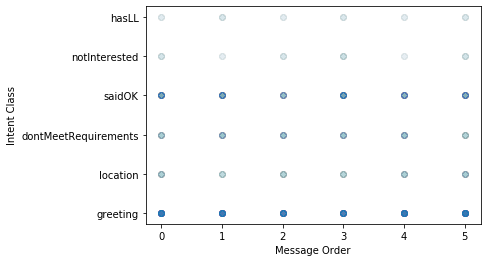

In [8]:
#Visualizing distribution of intent classification over message_orders (the dataset has fewer examples with class = 4,5)

x = np.array(data.message_order)
y = np.array(data.text_label)

plt.xlabel('Message Order')
plt.ylabel('Intent Class')

plt.scatter(x,y, alpha = 0.007)
plt.show()

In [9]:
message = np.array(data.text)
message_order = np.array(data.message_order)
labels = np.array(data.label)

for i in range(6):
    print('Examples of class ' + str(i+1) + ' =', np.sum(labels == i+1))

Examples of class 1 = 233
Examples of class 2 = 445
Examples of class 3 = 828
Examples of class 4 = 284
Examples of class 5 = 112
Examples of class 6 = 98


In [10]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
#shifting all data to lowercase and breaking sentences into word tokens

def cleaning(message):
    words = []
    for s in message:
        clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
        w = word_tokenize(clean)
        words.append([i.lower() for i in w])
    
    return words

In [12]:
cleaned_words = cleaning(message)
print(cleaned_words[0:10])

[['good', 'morning'], ['location'], ['hi'], ['hi'], ['hello'], ['sir'], ['k'], ['on', 'thanks'], ['hii'], ['sir', 'i', 'dnt', 'have', 'two', 'wheeler']]


In [13]:
#Creating feature word_count and checking its relation to the data using histogram

word_count = []
for i in range(len(cleaned_words)):
    word_count.append(len(cleaned_words[i]))

word_count = np.array(word_count)
word_count[0:10]

array([2, 1, 1, 1, 1, 1, 1, 2, 1, 6])

(array([ 38.,   0., 410.,   0., 630.,   0.,  72.,   0.,  11.,  23.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

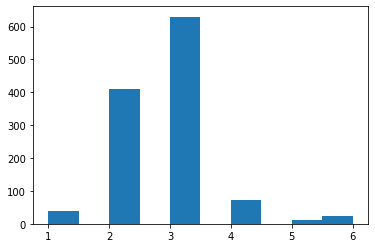

In [14]:
mask = (word_count <= 1)
x = labels[mask] 
plt.hist(x)

In [15]:
#Non- English messages have 0 word count because of how the cleaning_sentences function was defined

message[np.where(word_count == 0)]

array([" 'बाइक नहीं है'", " 'मेरे पास बाइक नही है'", " 'లేదు'",
       " 'जय महाराष्ट्र'", " 'లేదు'", " 'శుభోదయం'",
       " '👾 ಬೆಳಗಿನ ಶುಭೋದಯ ಗಳು'", " 'कुटे है'", " '", " 'नमस्कार'",
       " '😉✌'"], dtype=object)

In [16]:
#standard keras tokenizer procedure

def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [17]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = len(max(cleaned_words, key = len))

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 812 and Maximum length = 19


In [18]:
#obtaining the word vectors

vectors = word_tokenizer.texts_to_sequences(cleaned_words)
vectors[0:4]

#using matrix decomposition of co-occurence matrix won't work well here clearly due to the nature of the 'corpus'.

[[16, 22], [11], [1], [1]]

In [19]:
#adding zero padding to make size of all vectors equal

def padding_doc(vectors, max_length):
  return(pad_sequences(vectors, maxlen = max_length, padding = "post"))

padded_doc = padding_doc(vectors, max_length)

In [20]:
#Adding message order as an input feature

#message_order = message_order.reshape(2000,1)

#padded_doc = np.append(padded_doc, message_order, axis=1)
#padded_doc.shape

In [21]:
#adding word count as a feature

word_count = np.array(word_count).reshape(2000,1)
padded_doc = np.append(padded_doc, word_count, axis=1)
max_length = padded_doc.shape[1]

padded_doc.shape, max_length

((2000, 20), 20)

In [22]:
#using one_hot representation for intent labels

labels = labels.reshape(2000,1)
labels.shape

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
Y_onehot = encoder.fit_transform(labels)
Y_onehot.shape

C:\Users\asus\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(2000, 6)

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, Y_onehot, shuffle = True, test_size = 0.2)

In [25]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (1600, 20) and train_Y = (1600, 6)
Shape of val_X = (400, 20) and val_Y = (400, 6)


In [26]:
#At this point we have our word vectors, output labels, training and validation datasets, and we can append the
#message_order value as a feature to the word vectors and feed the data to a model

In [27]:
#But our data is multilingual, to deal with that, we can first separate the data based on language and then train our model

In [28]:
#Using LSTM

def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
#   model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(6, activation = "softmax"))
  
  return model

In [29]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

W0728 22:19:22.079233 14440 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 22:19:22.099357 14440 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 22:19:22.102242 14440 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 22:19:22.529126 14440 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_w

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 128)           103936    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 375,526
Trainable params: 271,590
Non-trainable params: 103,936
_________________________________________________________________


In [30]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = model.fit(train_X, train_Y, epochs = 50, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

W0728 22:19:22.833321 14440 deprecation.py:323] From C:\Users\asus\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 5s 3ms/step - loss: 1.6599 - acc: 0.3419 - val_loss: 1.4810 - val_acc: 0.4275

Epoch 00001: val_loss improved from inf to 1.48099, saving model to model.h5
Epoch 2/50
1600/1600 [==============================] - 3s 2ms/step - loss: 1.4891 - acc: 0.4450 - val_loss: 1.3019 - val_acc: 0.5125

Epoch 00002: val_loss improved from 1.48099 to 1.30186, saving model to model.h5
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/step - loss: 1.3504 - acc: 0.5200 - val_loss: 1.1264 - val_acc: 0.6450

Epoch 00003: val_loss improved from 1.30186 to 1.12639, saving model to model.h5
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/step - loss: 1.2003 - acc: 0.5931 - val_loss: 0.9738 - val_acc: 0.6475

Epoch 00004: val_loss improved from 1.12639 to 0.97382, saving model to model.h5
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/step - loss: 1.0878 - acc: 0.6

1600/1600 [==============================] - 2s 1ms/step - loss: 0.2850 - acc: 0.9106 - val_loss: 0.3466 - val_acc: 0.8950

Epoch 00041: val_loss did not improve from 0.34310
Epoch 42/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.2607 - acc: 0.9281 - val_loss: 0.4143 - val_acc: 0.8775

Epoch 00042: val_loss did not improve from 0.34310
Epoch 43/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.2511 - acc: 0.9325 - val_loss: 0.4222 - val_acc: 0.8775

Epoch 00043: val_loss did not improve from 0.34310
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.2221 - acc: 0.9369 - val_loss: 0.4409 - val_acc: 0.8775

Epoch 00044: val_loss did not improve from 0.34310
Epoch 45/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.2454 - acc: 0.9375 - val_loss: 0.3578 - val_acc: 0.8900

Epoch 00045: val_loss did not improve from 0.34310
Epoch 46/50
1600/1600 [==============================] - 3s 2ms/step - loss: 

In [31]:
#We got a validation accuracy 0f ~88%

In [32]:
#Making some predictions

X = ["I have ll not dl", 'hy! were your office', 'tell me address', 'Hiiii!', 'oh ohk', 'stop messaging me', 
     'i dont have bike', 'good morning where is job', 'good morning tell address', 
     'good morning tell address of job']

pred = cleaning(X)
vector = word_tokenizer.texts_to_sequences(pred)
padded = padding_doc(vector, max_length =19)

count = []
for i in range(len(pred)):
    count.append(len(pred[i]))
    
count = np.array(count).reshape(len(count),1)
padded = np.append(padded, count , axis=1)

intent = [inv_map[model.predict_classes(padded)[i] + 1] for i in range(len(X))]
intent

['hasLL',
 'location',
 'location',
 'greeting',
 'saidOK',
 'notInterested',
 'dontMeetRequirements',
 'location',
 'greeting',
 'location']